#1. Pretrained Model Loading

##1.1. Load Pretrained Model

In [ ]:
## 필요한 모듈 import

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision 
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import copy

In [ ]:
# Pre-trained ResNet 가져오기
Resnet = torchvision.models.resnet18(pretrained=True) # 해당 부분을 False로 바꾸면 구조만 가져온다

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Structure of ResNet18**

![image.png](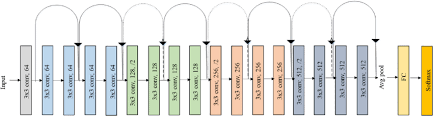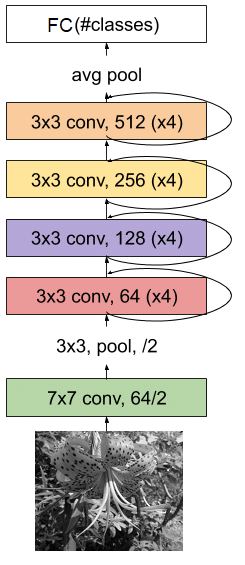)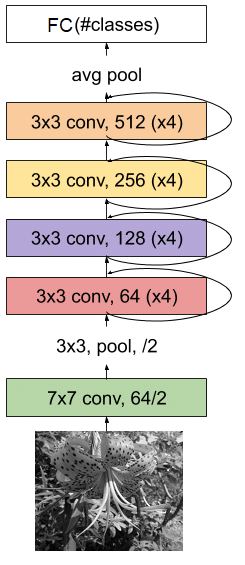

In [ ]:
# 위의 사진과 맞는지 불러온 ResNet 구조 확인
for name,child in Resnet.named_children(): # ResNet에서는 named_children 객체를 통해 각 layer의 이름과 정보를 가져올 수 있음
  print('Layer Name : ',name) # 각 layer의 이름 확인
  print('Layer Info. : ',child) # 각 layer의 정보 확인
  print()

Layer Name :  conv1
Layer Info. :  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Layer Name :  bn1
Layer Info. :  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Layer Name :  relu
Layer Info. :  ReLU(inplace=True)

Layer Name :  maxpool
Layer Info. :  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

Layer Name :  layer1
Layer Info. :  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps

##1.2. Load Dataset

In [ ]:
## 데이터셋 로드 
## 제공된 사람 얼굴 이미지를 사용할 것
from torchvision.datasets import ImageFolder
import os

data_dir = 'face_dataset'
path = {x: os.path.join('/content/drive/MyDrive/',data_dir,'facescrub_'+x) for x in ['train', 'test'] } # Train, Test 경로 지정
## local에 이미지를 저장했으면 저장한 경로만 찾아서 붙여넣어 주기
print(path)
train_data = ImageFolder(path['train'], transforms.Compose([transforms.ToTensor()]))

{'train': '/content/drive/MyDrive/face_dataset/facescrub_train', 'test': '/content/drive/MyDrive/face_dataset/facescrub_test'}


In [ ]:
## Train data의 개수 확인 
len(train_data)

4000

##1.3. Data Preprocessing

In [ ]:
## Input Normalize를 위해 train data의 평균과 표준편차를 구한다
avgRGB = [np.mean(x.numpy(), axis=(1,2)) for x,_ in train_data]
# train_data[i] : 이미지 폴더를 통해 만들어진 train data의 [i]는 실제 텐서로 바뀐 이미지의 픽셀값이 저장되어 있음
# train_data[i][0] : [i][0]에는 각 이미지의 label이 들어가 있음
stdRGB = [np.std(x.numpy(), axis=(1,2)) for x,_ in train_data]
avgR = np.mean([avg[0] for avg in avgRGB])
avgG = np.mean([avg[1] for avg in avgRGB])
avgB = np.mean([avg[2] for avg in avgRGB])
stdR = np.mean([std[0] for std in stdRGB])
stdG = np.mean([std[1] for std in stdRGB])
stdB = np.mean([std[2] for std in stdRGB])

In [ ]:
## 위의 평균, 표준편차 연산 코드는 시간이 매우 오래걸리므로 과제 및 사용 시 해당 셀의 값 사용
print('Average of Each Channel : ',avgR,avgG,avgB)
print('Standard Deviation of Each Channel : ',stdR,stdG,stdB)

Average of Each Channel :  0.6565039 0.4843807 0.4084822
Standard Deviation of Each Channel :  0.20245129 0.17317267 0.1622832


In [ ]:
avgR = 0.6565039 
avgG = 0.4843807
avgB = 0.4084822
stdR = 0.20245129
stdG = 0.17317267
stdB = 0.1622832

In [ ]:
## 데이터 전처리를 위한 과정

data_transforms = {
    'facescrub_train': transforms.Compose([
        # 이미지의 크기를 바꿔준다. (Pre-trained 시 이용된 이미지의 크기와 현재 데이터의 크기가 다름)
        # 과제에서는 Input Size를 변경하지 않고, Stride와 Kernel Size를 바꿔서 해보기
        transforms.Resize((224,224)), # 비율에 맞게 Resize해주기
        #transforms.CenterCrop(224), # 가운데 부분만 가져오기
        # 이미지 증강
        transforms.RandomHorizontalFlip(), # 수평으로 뒤집기
        transforms.RandomVerticalFlip(), # 수직으로 뒤집기
        # 이미지를 텐서로 변경
        transforms.ToTensor(),
        # Input 값 Normalize 해주기 ( 각 채널의 평균 값과 표준편차 값으로 정규화 해줌 )
        transforms.Normalize([avgR, avgG, avgB], [stdR, stdG, stdB])
    ]),
    # 위와 동일한 과정 Test set에 대해 진행하기
    'facescrub_test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([avgR, avgG, avgB], [stdR, stdG, stdB])
    ]),
}

In [ ]:
## 앞서 정의한 data_transforms를 이용해 실제 train과 test 이미지셋을 만들어 준다
image_datasets = {x: datasets.ImageFolder(os.path.join('/content/drive/MyDrive/face_dataset/', x),
                                          data_transforms[x]) for x in ['facescrub_train', 'facescrub_test']}

In [ ]:
## Train과 Testset의 크기 확인
data_sizes = {x: len(image_datasets[x]) for x in ['facescrub_train', 'facescrub_test']}
print(data_sizes['facescrub_train'])
print(data_sizes['facescrub_test'])

4000
1000


In [ ]:
## Dataloader를 설정해 준다
dataloaders = {x: torch.utils.data.DataLoader(
                       image_datasets[x], batch_size=16, # 이 부분에서 batch_size를 설정할 수 있음 
                       shuffle=True, # train data를 batch로 묶을 때 섞을 것인지 결정
                       num_workers=2) # Dataloader가 data를 읽어들일 때 사용할 스레드의 개수 (GPU 사용량을 결정)
                                            for x in ['facescrub_train', 'facescrub_test']}
## class 이름 설정 
class_names = image_datasets['facescrub_train'].classes 

## 어떤 device를 이용할 것인지 결정한다 (gpu 불가능하면 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda:0


#2. Model Fine-Tune

세 가지의 전이학습을 진행할 것임

1. Pre-trained ResNet 그대로 이미지만 바꿔서 사용
2. Conv layer4 포함 fine tunning하여 사용
3. FC layer를 추가하여 사용

##2.1. Common Task

In [ ]:
## 세 전이학습에 사용할 ResNet 각각 load
Resnet_1 = torchvision.models.resnet18(pretrained=True) 
Resnet_2 = torchvision.models.resnet18(pretrained=True)
Resnet_3 = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
## Fine Tunning위해 ResNet model layer의 이름 다시 확인
for name,child in Resnet.named_children(): 
  print('Layer Name : ',name)

Layer Name :  conv1
Layer Name :  bn1
Layer Name :  relu
Layer Name :  maxpool
Layer Name :  layer1
Layer Name :  layer2
Layer Name :  layer3
Layer Name :  layer4
Layer Name :  avgpool
Layer Name :  fc


###(1) Output Layer Handling

In [ ]:
## 현재 이미지 데이터의 class 수에 맞게 fc layer 조절
num_ftrs = Resnet.fc.in_features # ResNet의 'fc' 라는 layer에 들어오는 feature 확인
# class_names 에는 우리 이미지의 class들이 들어가 있음 (위에서 할당해 놓음)
Resnet_1.fc = nn.Linear(num_ftrs,len(class_names)) # 'fc' layer의 input은 feature size로 output은 우리 이미지의 class 개수로
Resnet_2.fc = nn.Linear(num_ftrs,len(class_names)) # 위와 동일
Resnet_3.fc = nn.Linear(num_ftrs,len(class_names)) # 위와 동일

In [ ]:
## 그대로 가져왔던 Resnet과 fc layer의 weight 개수 비교
print(Resnet_1.fc.weight.shape)
print(Resnet.fc.weight.shape)

torch.Size([100, 512])
torch.Size([1000, 512])


### (2) Weight Initialization

In [ ]:
## Weight Initialization 
'''
위의 cell에서 지정해 준 Resnet_1, 2, 3의 output layer에 대해 가중치 초기화를 진행할 수 있음.
기본적으로 torch는 Kaiming he 초기화를 defalt로 갖고 있음
세 fc layer 모두 Kaiming 초기화를 수동으로 시켜줄 것 
'''
torch.nn.init.kaiming_normal_(Resnet_1.fc.weight)
torch.nn.init.kaiming_normal_(Resnet_2.fc.weight)
torch.nn.init.kaiming_normal_(Resnet_3.fc.weight) 

## 물론 다른 종류의 초기화도 가능하다

# Normal distribution
#torch.nn.init.normal_(Resnet_1.weight)
# Xavier initialization
#torch.nn.init.xavier_uniform_(Resnet_1.weight)
# Kaiming initialization
#torch.nn.init.kaiming_uniform_(Resnet_1.weight)

Parameter containing:
tensor([[ 0.0280,  0.0440,  0.0242,  ...,  0.0441, -0.0116,  0.0191],
        [-0.0117, -0.1360, -0.0157,  ...,  0.0892,  0.0234, -0.0769],
        [ 0.0237,  0.0710,  0.0207,  ..., -0.0232,  0.0295,  0.0035],
        ...,
        [-0.1310, -0.0365,  0.0022,  ...,  0.0312, -0.0932, -0.1128],
        [-0.0591, -0.0393,  0.0106,  ...,  0.0196,  0.0478, -0.0557],
        [-0.0354, -0.0278,  0.0827,  ..., -0.0039,  0.0512,  0.0245]],
       requires_grad=True)

In [ ]:
## 초기화 확인
print('Original ResNet fc layer weights')
print(Resnet.fc.weight)
print('Modified ResNet fc layer weights')
print(Resnet_1.fc.weight)

Original ResNet fc layer weights
Parameter containing:
tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
        [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
        [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
        ...,
        [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
        [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
        [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
       requires_grad=True)
Modified ResNet fc layer weights
Parameter containing:
tensor([[-0.0203, -0.0287, -0.0715,  ..., -0.1063,  0.0128, -0.0600],
        [ 0.0088, -0.0983, -0.0127,  ...,  0.0072,  0.0209, -0.0305],
        [ 0.0745, -0.1597, -0.0175,  ..., -0.0459, -0.0154,  0.1317],
        ...,
        [ 0.2165,  0.0167, -0.0168,  ..., -0.0107, -0.0844,  0.0968],
        [-0.0778, -0.0480,  0.0135,  ..., -0.1119, -0.0093,  0.0743],
        [-0.0038,  0.0337,  0.0661,  ..., -0.1335,  0.0822,  0.039

###(3) Train, Test Functions

In [ ]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [ ]:
## Train 함수 정의

def train(model,epoch,optimizer,criterion,scheduler=None,save_every=None):
    ## 각 단계의 loss 및 accuracy 저장할 list 생성

    print(f'\n[ Train epoch: {epoch+1} ]')

    model.train() # Train 단계임을 선업

    running_loss = 0.0
    batch_losses = []
    total = 0
    correct = 0

    for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_train']): # Train data 가져오기
        inputs, targets = inputs.to(device), targets.to(device) # dataloader의 input image와 label도 device에 넣어준다
      
        optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs) # Prediction value 계산 (Output 계산)
        loss = criterion(outputs, targets) # outputs와 원래 label인 targets 사이 loss 계산
        loss.backward() # 계산한 loss 기반으로 gradient 값 계산
        optimizer.step() # weight parameter update
        if scheduler != None:
            if batch_idx in [80, 160, 200]:
                scheduler.step() # Scheduler update

        total += targets.size(0) # batch 데이터 개수 더하기
        running_loss += loss.item()
        batch_losses.append(loss.item())
        
        _, predicted = outputs.max(1) # 확률값 가장 높게 나타난 클래스
        correct += (predicted == targets).sum().item() # 현재 batch 내에서 알맞게 분류한 이미지 개수 더하기
        
        if batch_idx % 50 == 49:
            ## 학습 중간 성능 확인
            print(f'\nCurrent batch: {str(batch_idx+1)}')
            print(f'Average train loss of recent 50 batches: {running_loss / 50}') 
            running_loss = 0.0

        if save_every != None:
         if (batch_idx % save_every == 0): # 얼마만큼의 iteration마다 저장할 것인지를 설정
              directory = os.path.join(save_path, 'Resnet') # 경로 설정
              if not os.path.exists(directory): # 경로가 없다면 새로 만듦
                  os.makedirs(directory)
              torch.save({ 
                  # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
                  'epoch': epoch, 
                  'iteration': batch_idx,
                  'model': model.state_dict(),
                  'opt': optimizer.state_dict(),
                  'loss': loss
                  #,'sch': scheduler.state_dict()
                  }, os.path.join(directory, '{}ep_{}iter_{}.tar'.format(epoch,batch_idx,'checkpoint')))

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_train_loss.append(avg_loss)
    seq_train_acc.append(100*correct/total)
    print('\nTotal train accuarcy:', 100. * correct / total) # 전체 데이터 개수에서 맞게 예측한 비율
    print('Total train loss:', avg_loss)

In [ ]:
def test(model,epoch,criterion):
    print(f'\n[ Test epoch: {epoch+1} ]')

    model.eval() # Test time임을 선언

    loss = 0
    batch_losses = []
    correct = 0
    total = 0

    with torch.no_grad(): # gradient update 안함 - eval과 torch.no_grad는 하나의 세트
        for batch_idx, (inputs, targets) in enumerate(dataloaders['facescrub_test']):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            batch_losses.append(loss.item())

            total += targets.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == targets).sum().item()

    avg_loss = sum(batch_losses) / len(batch_losses)
    seq_test_loss.append(avg_loss)
    seq_test_acc.append(100 * correct / total)
    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', avg_loss)

##2.2. Baseline Model 

여기서는 Pre-trained ResNet 그대로 사용할 것

###(1) Freeze the Other Layers

In [ ]:
## 새로 정의한 마지막 output layer 제외하고 다른 parameter 얼리기
for name,child in Resnet_1.named_children():
  for param in child.parameters():
    if name != 'fc':   # 'fc' 이름의 layer만 제외
      param.requires_grad = False # 제외된 layer 이외 모든 layer의 parameter 얼리기

In [ ]:
## 다른 parameter가 얼었는지 확인
for name,child in Resnet_1.named_children():
  for param in child.parameters():
    if name == 'layer4' or name == 'fc':# 비교확인을 위해 layer4의 parameter도 출력
      print(name,param)
## 얼지 않은 layer의 parameter는 마지막 부분에
## 'requires_grad = True' 라고 써있음

layer4 Parameter containing:
tensor([[[[-1.1645e-02, -1.9010e-02, -2.1876e-02],
          [ 2.0482e-02,  2.3962e-02,  2.9161e-02],
          [ 4.3672e-02,  3.3278e-02,  4.9908e-02]],

         [[-7.4040e-03,  2.8083e-03, -4.7339e-03],
          [ 6.9030e-03,  1.4271e-02, -3.6954e-03],
          [-3.1341e-03,  1.3736e-02,  1.6127e-03]],

         [[ 1.8676e-02, -1.0553e-02, -1.4233e-02],
          [ 8.9944e-03, -2.5068e-03, -1.2145e-02],
          [-4.9455e-03, -2.9206e-02, -9.6385e-03]],

         ...,

         [[-1.2655e-02,  1.7691e-02,  9.8264e-04],
          [ 7.4271e-03,  7.6115e-03,  1.1135e-02],
          [ 2.3242e-02,  1.1058e-02,  4.0498e-03]],

         [[ 1.8557e-02,  1.2472e-02,  1.7220e-02],
          [-4.8544e-03,  8.3627e-03,  2.2811e-02],
          [-5.1675e-03,  2.3264e-02,  3.4068e-02]],

         [[ 2.4934e-02,  2.2373e-02,  4.2614e-02],
          [ 1.3486e-02,  1.6760e-03,  1.3019e-02],
          [-6.2821e-03, -1.5112e-03, -8.9229e-03]]],


        [[[-9.8089e-04, 

In [ ]:
## 지정한 device에 학습시킬 모델 얹어주기
Resnet_1.to(device)
Resnet_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

###(2) Cost Function, Opimizer

In [ ]:
## Cost Function과 Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Resnet_1.parameters(), lr=0.001)

###(3) Learning Rate Scheduler

In [ ]:
## Learning Rate Scheduler 설정 (선택사항)
'''
exp_lr_scheduler =optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# 역시 더 많은 lr scheduler가 존재함 
# Cosine Warm Restarts 
lr = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=,T_mult=) 
'''

'\nexp_lr_scheduler =optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)\n# 역시 더 많은 lr scheduler가 존재함 \n# Cosine Warm Restarts \nlr = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=,T_mult=) \n'

In [ ]:
num_epochs = 2

In [ ]:
for epoch in range(0,num_epochs):
  train(Resnet_1,epoch,optimizer,criterion,save_every=10)
  test(Resnet_1,epoch,criterion)


[ Train epoch: 1 ]

Current batch: 50
Average train loss of recent 50 batches: 4.225871648788452


KeyboardInterrupt: ignored

In [ ]:
Resnet_1.fc.weight

Parameter containing:
tensor([[-0.0490, -0.0292, -0.0987,  ..., -0.0993,  0.0062, -0.0621],
        [ 0.0179, -0.0901, -0.0228,  ...,  0.0100,  0.0161, -0.0381],
        [ 0.0768, -0.1511, -0.0246,  ..., -0.0500, -0.0344,  0.1243],
        ...,
        [ 0.2217,  0.0180, -0.0203,  ..., -0.0194, -0.0884,  0.0841],
        [-0.0976, -0.0581,  0.0269,  ..., -0.1191, -0.0131,  0.0872],
        [-0.0120,  0.0355,  0.0565,  ..., -0.1414,  0.0689, -0.0025]],
       device='cuda:0', requires_grad=True)

In [ ]:
## 성능 확인
plt.plot(range(num_epochs), seq_train_loss, label="Train loss")
plt.plot(range(num_epochs), seq_test_loss, label="Test loss")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
## 성능 확인
plt.plot(range(num_epochs), seq_train_acc['Resnet_1'], label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc['Resnet_1'], label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

##2.3. Model2 

Model2는 fc layer와 conv4 (layer4)를 fine-tunning 할 것

In [ ]:
## 해당되는 layer 제외하고 다른 parameter 얼리기
for name,child in Resnet_2.named_children():
  for param in child.parameters():
    if name != 'fc' and name != 'layer4':   # 'fc', 'layer4' 이름의 layer만 제외
      param.requires_grad = False # 제외된 layer 이외 모든 layer의 parameter 얼리기

In [ ]:
## 지정한 device에 학습시킬 모델 얹어주기
Resnet_2.to(device)
Resnet_2

In [ ]:
## Learning Rate Scheduler 설정 (선택사항)
#exp_lr_scheduler =optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [ ]:
for epoch in range(0,num_epochs):
  train(Resnet_2,epoch,optimizer,criterion)
  test(Resnet_2,epoch,criterion)

In [ ]:
## 성능 확인
plt.plot(range(num_epochs), seq_train_loss, label="Train loss")
plt.plot(range(num_epochs), seq_test_loss, label="Test loss")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
## 성능 확인
plt.plot(range(num_epochs), seq_train_acc['Resnet_2'], label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc['Resnet_2'], label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

##2.4. Model3

Model3는 마지막에 fc layer를 추가할 것임

In [ ]:
## Sequential을 이용해 fc layer를 새롭게 구성 (2개를 덧붙임)
new_FC = nn.Sequential(
 nn.Linear(in_features = num_ftrs, out_features = num_ftrs),
 nn.ReLU(),
 nn.Linear(in_features = num_ftrs, out_features = num_ftrs),
 nn.ReLU(),
 nn.Linear(in_features = num_ftrs, out_features = len(class_names))
)
Resnet_3.fc = new_FC

In [ ]:
## 해당되는 layer 제외하고 다른 parameter 얼리기
for name,child in Resnet_3.named_children():
  for param in child.parameters():
    if name != 'fc':   # 'fc' 이름의 layer만 제외
      param.requires_grad = False # 제외된 layer 이외 모든 layer의 parameter 얼리기

In [ ]:
## 지정한 device에 학습시킬 모델 얹어주기
Resnet_3.to(device)
Resnet_3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
## Cost Function과 Optimizer 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Resnet_2.parameters(), lr=0.001)

In [ ]:
## Learning Rate Scheduler 설정 (선택사항)
#exp_lr_scheduler =optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
seq_train_loss = []
seq_test_loss = []
seq_train_acc = []
seq_test_acc = []

In [ ]:
for epoch in range(0,num_epochs):
  train(Resnet_3,epoch,optimizer,criterion)
  test(Resnet_3,epoch,criterion)

In [ ]:
## 성능 확인
plt.plot(range(num_epochs), seq_train_acc['Resnet_3'], label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc['Resnet_3'], label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
## 성능 확인
plt.plot(range(num_epochs), seq_train_acc['Resnet_3'], label="Train Accuracy")
plt.plot(range(num_epochs), seq_test_acc['Resnet_3'], label="Test Accuracy")
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#3. Model Saving

두 가지 방법으로 저장을 할 것

1. 학습이 끝난 모델을 저장할 때
2. 학습 도중에 모델을 저장할 때 

###(1) Save the Model (after training)

In [ ]:
## 저장할 경로 설정
save_path = '/content/drive/MyDrive/save'

In [ ]:
## 모델 저장
torch.save(Resnet_1.state_dict(), save_path)

###(2) Save the Model (on training)

In [ ]:
## 모델 저장
## 해당 코드는 train코드 내부에 들어가 있어야 함
## 설명을 위해 이 부분만 따로 빼놓음
'''
if (batch_idx % save_every == 0): # 얼마만큼의 iteration마다 저장할 것인지를 설정
            directory = os.path.join(save_path, model) # 경로 설정
            if not os.path.exists(directory): # 경로가 없다면 새로 만듦
                os.makedirs(directory)
            torch.save({
                # 학습 중간에 저장하려 하는 모든 것들을 dict로 서술
                'epoch': epoch 
                'iteration': batch_idx,
                'model': model.state_dict()
                'opt': optimizer.state_dict(),
                'loss': loss,
                'sch': scheduler.state_dict()
            }, os.path.join(directory, '{}ep_{}iter_{}.tar'.format(epoch,batch_idx,'checkpoint')))
            # 저장할 이름 바로 위에서 설정
            # 본인이 알아보기 편한 이름으로 설정하면 됨
'''

#4. Model Load

In [ ]:
## Load 할 모델에 대한 정보 입력
checkpoint_ep = 1
checkpoint_iter = 50

model_name = 'Resnet'
loadFilename = os.path.join(save_path, model_name,
                          '{}ep_{}iter_checkpoint.tar'.format(checkpoint_ep-1,checkpoint_iter))

# loadFilename이 있을 때 모델 불러오기
if loadFilename:
    # 모델을 학습할 때와 같은 기기에서 불러오는 경우
    checkpoint = torch.load(loadFilename)
    # GPU에서 학습한 모델을 CPU로 불러오는 경우
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    optimizer_sd = checkpoint['opt']
    model_sd = checkpoint['model']
    #scheduler_sd = checkpoint['sch']
    epoch_sd = checkpoint['epoch']
    loss_sd = checkpoint['loss']

# Model 및 Optimizer 초기화 
model = copy.deepcopy(Resnet_1)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 불러온 값들로 변경
model.load_state_dict(model_sd) # 불러온 모델로 변경
optimizer.load_state_dict(optimizer_sd) # 불러온 optimizer로 변경
epoch = checkpoint['epoch'] # 불러온 epoch 설정 
loss = checkpoint['loss'] # 불러온 loss 설정

# 원하는 mode로 진행
model.eval()
# - or -
#model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 50번째 iter에서 학습을 멈추고 저장 후 불러옴
model.fc.weight

Parameter containing:
tensor([[-0.0490, -0.0292, -0.0987,  ..., -0.0993,  0.0062, -0.0621],
        [ 0.0179, -0.0901, -0.0228,  ...,  0.0100,  0.0161, -0.0381],
        [ 0.0768, -0.1511, -0.0246,  ..., -0.0500, -0.0344,  0.1243],
        ...,
        [ 0.2217,  0.0180, -0.0203,  ..., -0.0194, -0.0884,  0.0841],
        [-0.0976, -0.0581,  0.0269,  ..., -0.1191, -0.0131,  0.0872],
        [-0.0120,  0.0355,  0.0565,  ..., -0.1414,  0.0689, -0.0025]],
       device='cuda:0', requires_grad=True)

In [ ]:
# 50번째 iter에서 멈춘 학습 불러온 것과 동일함을 알 수 있음
Resnet_1.fc.weight

Parameter containing:
tensor([[-0.0490, -0.0292, -0.0987,  ..., -0.0993,  0.0062, -0.0621],
        [ 0.0179, -0.0901, -0.0228,  ...,  0.0100,  0.0161, -0.0381],
        [ 0.0768, -0.1511, -0.0246,  ..., -0.0500, -0.0344,  0.1243],
        ...,
        [ 0.2217,  0.0180, -0.0203,  ..., -0.0194, -0.0884,  0.0841],
        [-0.0976, -0.0581,  0.0269,  ..., -0.1191, -0.0131,  0.0872],
        [-0.0120,  0.0355,  0.0565,  ..., -0.1414,  0.0689, -0.0025]],
       device='cuda:0', requires_grad=True)